# Introduction
In this notebook, we implement a probablistic model to the non-contractual setting with continous purchase opportunity. The probabilistic approach models customers' repeat-buying behavior based on three main attributes; "*recency*", *frequency* and/or *monetary* (in case of lifetime value). It is a simple model that is easy to train and produces good results under the assumptions of the approach.  The model can predict the expected number of transactions, the probability of observation $x$ transaction for a period $t$, and the probablity of churning (churning rate) at the customer level, thus the customer lifetime value
1. Recency is the difference between last purchase date and the first one (when the customer's last transaction occured)
i.e., the time interval for which transactions have occured
2. Frequency is the number of repeat-buying (more than once) (how many transactions the customer made in a specified time period) .

Here, we do not model the pruchases but rather the transactions, i.e., +1 count is added 
if a transaction happens at any given day regardless of the number of purchases (number of transacions can be greater than purchases).
There are two well-known models; Pareto/NBD and BG/NBD. The latter is very similar to the former, which was the first method introduced in the literature to compute clv<br>
The two methods different just a bit in the model assumptions. The first one assumes that the customer can become inactive at any time while the second model assumes that the customer is inactive after the some number of transactions,
or inactive immediatly after a transaction.<br>
**Notation** 
> $x$ is the number of transactions observed in the ime period $(0,T]$ (0, excluded in the interval, is the first (or the last) transaction within the observation period)<br>
> $t_x$ $(0<t_x\le T)$ is the time of the last transation <br>
> $T$ is the age of the customer (it is equal to the duration between a customer's first purchase and the end of the period under study)

**Pareto/NBD Model**<br>
The time to "dropout/churn" is modeled using Pareto (exponential-gamma mixture) and transaction while active is modelled using the NBD  (Poison-gamma mixture)<br>
_Assumptions :_
1. While active, the number of transaction made by a customer in a time period of length $t$ is distributed Poisson with mean $\lambda t$, where $\lambda$ is the transaction rate per unit of time
2. The prior distribution of $\lambda$ follows gamma distribution with shape parameter $r$ and scale parameter $\alpha$
3. Customer can become inactive at any time is distributed exponential with dropout rate $\mu$ (churning rate per unit of time)
4. The prior distribution of $\mu$ follows gamma distribution with parameters $s$ and $\beta$
5. $\lambda$ and $\mu$ vary independently across customers

**BG/NBD Model**<br>
The time to "dropout" occurs immediately after a purchase and is modeled using the beta-geometric (BG) model<br>
_Assumptions :_
1. Item 1 and 2 for Pareto/NBD
2. After any transaction, customer becomes inactive with probability $p$. Hence the dropout follows geometric distribution ($p(1-p)^{j-1}$
3. The prior distribution of $p$ follows a beta distribution with parameters $a$ and $b$
4. $\lambda$ and $p$ vary independently across customers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
%matplotlib inline

In [2]:
transactions = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')
transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


A customer can have multiple invoices. An invoice is associated with only one customer. So to predict the number of transactons at customer level, we should drop any missing CustomerID

In [3]:
#We see that UK has the most transactions
transactions.Country.describe()

count             541909
unique                38
top       United Kingdom
freq              495478
Name: Country, dtype: object

In [4]:
uk_transactions = transactions.query("Country=='United Kingdom'")
uk_transactions.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
#check missing values
uk_transactions.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [6]:
#using ML approach X=[StockCode, Description, InvoiceDate, UnitPrice, CustomerID], y=Quantity

In [7]:
#delete the column Description
uk_transactions.drop(columns=['Description', 'Country'], inplace=True)
#Remove missing CustomerID
uk_transactions.dropna(inplace=True)
uk_transactions.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0


In [8]:
uk_transactions.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


Negative values in Quantity are returned items. Given that we are intereseted in transactions, we need only to consider strictly positive quantities. If however, we were interested in purchase behaviour then these returned items should be included as it cancels out the purchase.

In [9]:
#uk_data.drop_duplicates()
uk_transactions = uk_transactions.query("Quantity>0.0")

In [10]:
uk_transactions['Amount'] = uk_transactions['Quantity'] * uk_transactions['UnitPrice']
#convert to datetime and extract date
uk_transactions['InvoiceDate'] = pd.to_datetime(uk_transactions['InvoiceDate']).dt.date
uk_transactions.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Amount
0,536365,85123A,6,2010-12-01,2.55,17850.0,15.30
1,536365,71053,6,2010-12-01,3.39,17850.0,20.34
2,536365,84406B,8,2010-12-01,2.75,17850.0,22.00
3,536365,84029G,6,2010-12-01,3.39,17850.0,20.34
4,536365,84029E,6,2010-12-01,3.39,17850.0,20.34


Text(0.5, 1.0, 'total daily transactions and unique customers')

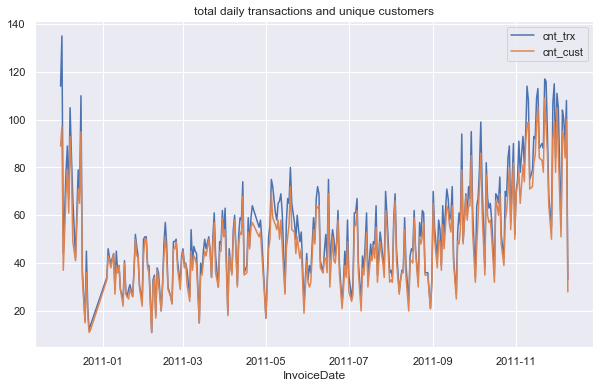

In [11]:
#Total daily Transaction
#Total daily customers (unique)
f, ax = plt.subplots()
uk_transactions.groupby(by='InvoiceDate').agg(cnt_trx=('InvoiceNo','nunique'),cnt_cust=('CustomerID','nunique')).reset_index().plot(x='InvoiceDate',y=['cnt_trx','cnt_cust'], figsize=(10,6), ax=ax)
plt.title('total daily transactions and unique customers')

There is a correlation between total number of transactions and total number of customers

In [12]:
#Total number of daily unique customers who visited the store
#uk_transactions.groupby(by='InvoiceDate').agg(nbr_unique_cust=('CustomerID','nunique')).reset_index().plot(x='InvoiceDate', y='nbr_unique_cust', legend=False, figsize=(10,6))
#uk_data.groupby(by='InvoiceDate').size()
#Number of unique customer
uk_transactions['CustomerID'].nunique()

3921

Text(0, 0.5, 'Avg Amount')

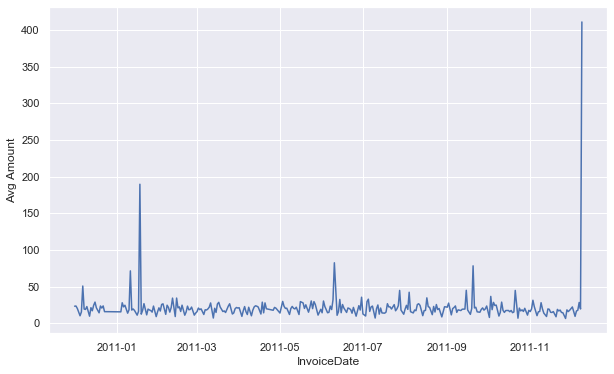

In [13]:
#Average daily profit
f, ax = plt.subplots()
uk_transactions.groupby(by='InvoiceDate').agg(avg_amount=('Amount','mean')).reset_index().plot(x='InvoiceDate', y='avg_amount', legend=False, figsize=(10,6), ax=ax)
plt.ylabel('Avg Amount')
#.sort_values('avg_amount',ascending=False)

Except the peaks which seem to occur around UK holidays, the average daily profit is kinda 'constant'

# BG/NBD Model

We use Python lifetimes library which provides all the tools we need

In [14]:
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data, calculate_alive_path
from lifetimes import BetaGeoFitter, GammaGammaFitter, ParetoNBDFitter
from lifetimes.plotting import plot_period_transactions, plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_transaction_rate_heterogeneity, plot_calibration_purchases_vs_holdout_purchases, plot_expected_repeat_purchases

In [15]:
#frequency_cal is the number of days, transactions have been made. 
#For one timer customer, we have frequeny, recency and monetary value = 0
#we divided the data into training and validation set 
summary_cal_holdout = calibration_and_holdout_data(uk_transactions, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-01',
                                        observation_period_end='2011-12-09', monetary_value_col='Amount' )
summary_cal_holdout.head()
#The T_call has been rounded to the nearest number in the lifetime implementation

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346.0,0.0,0.0,134.0,0.00000,0.0,0.000000,191
12747.0,5.0,171.0,178.0,346.56800,5.0,43.846042,191
12748.0,40.0,181.0,182.0,238.64575,73.0,7.452652,191
12749.0,0.0,0.0,22.0,0.00000,3.0,20.716538,191
12820.0,0.0,0.0,135.0,0.00000,3.0,16.080833,191


In [16]:
#convergence observed for penalizer_coef {0.1, 0.0001} 
#penalizer_coef=0.1, a: 0.00, alpha: 40.71, b: 0.00, r: 0.49
#penalizer_coef=0.0001, a: 0.00, alpha: 61.05, b: 0.00, r: 0.73
bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2471 subjects, a: 0.00, alpha: 61.05, b: 0.00, r: 0.73>


In [17]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,7.290938e-01,3.878716e-02,6.530709e-01,8.051166e-01
alpha,6.105185e+01,3.619252e+00,5.395812e+01,6.814559e+01
a,1.085086e-13,1.566284e-08,-3.069905e-08,3.069927e-08
b,4.642987e-06,6.701998e-01,-1.313587e+00,1.313596e+00


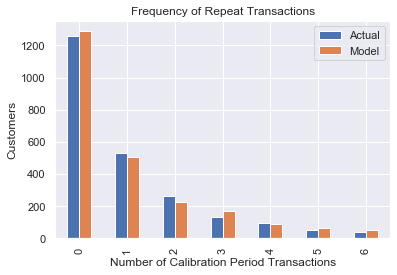

In [18]:
plot_period_transactions(bgf)

customers who made a single transaction within the observation period represents more than 30% (1200/3921) of total customers

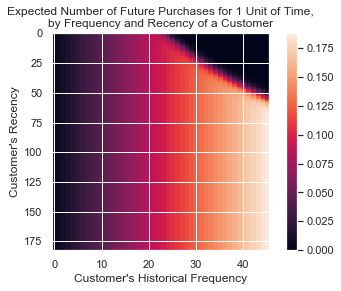

In [19]:
plot_frequency_recency_matrix(bgf)

We see that customers who bought more than let say 25th times within the period of observation and have the most recent transactions (bottom right corner) are expected to make a purchase in 1 day period <br>
However the top right corner corresponds to customers who bought a lot but long time ago

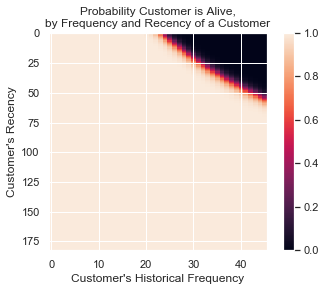

In [20]:
plot_probability_alive_matrix(bgf)

No handles with labels found to put in legend.


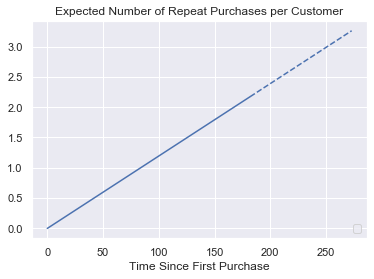

In [21]:
plot_expected_repeat_purchases(bgf)

Assessing model performance on validation set.  It is not bad! we can try the other value of _penalizer_coef_

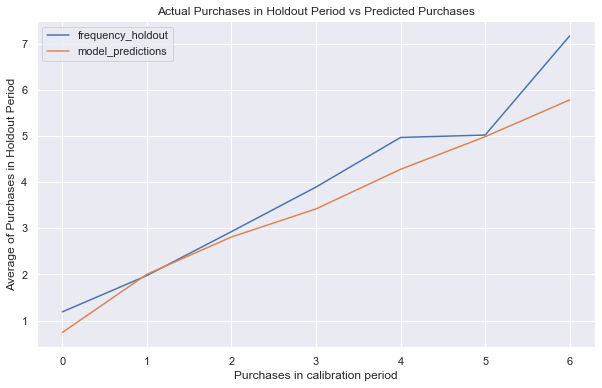

In [22]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(10,6))

In [23]:
#predict number of transactions 
t = 10 
summary_cal_holdout['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
summary_cal_holdout.head()
#summary_cal_holdout.sort_values(by='predicted_purchases').tail(5)
#bgf.predict(t, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,,,
12346.0,0.0,0.0,134.0,0.00000,0.0,0.000000,191,0.037379
12747.0,5.0,171.0,178.0,346.56800,5.0,43.846042,191,0.239659
12748.0,40.0,181.0,182.0,238.64575,73.0,7.452652,191,1.675737
12749.0,0.0,0.0,22.0,0.00000,3.0,20.716538,191,0.087788
12820.0,0.0,0.0,135.0,0.00000,3.0,16.080833,191,0.037189


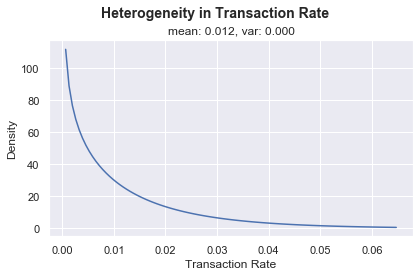

In [24]:
#transaction rate
plot_transaction_rate_heterogeneity(bgf)

We see that one timer customers have the highest density with transaction rate 0  but then when the transaction rate increases (loyal customers) the density decreases.

### Customer Lifetime Value

In [25]:
#using complete uk transactions
rfm_uk = summary_data_from_transaction_data(uk_transactions, 'CustomerID', 'InvoiceDate', 'Amount')
rfm_uk.head(10)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12747.0,10.0,367.0,369.0,383.745000
12748.0,113.0,373.0,373.0,298.360885
12749.0,3.0,210.0,213.0,1077.260000
12820.0,3.0,323.0,326.0,257.293333
12821.0,0.0,0.0,214.0,0.000000
12822.0,1.0,17.0,87.0,257.980000
12823.0,4.0,222.0,296.0,363.375000
12824.0,0.0,0.0,59.0,0.000000


In [26]:
#training on the complete uk transactions
bgf.fit(rfm_uk['frequency'], rfm_uk['recency'], rfm_uk['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 3921 subjects, a: 0.00, alpha: 69.85, b: 0.00, r: 0.83>


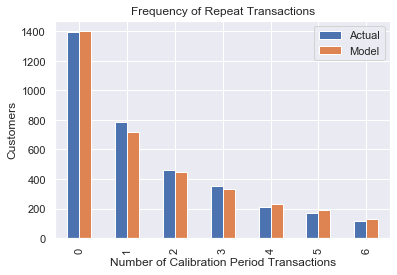

In [27]:
plot_period_transactions(bgf)

Using Gamma Gamma model to predict customer lifetime value (returning customers). The Gamma Gamma model assumes  a non correlation between frequency and monetary

In [28]:
returning_customers = rfm_uk.query("frequency>0")
returning_customers[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.009519
monetary_value,0.009519,1.000000


We could have split the data into training and validation to select the Gamma Gamma model that fits well our data (monetary value)

In [29]:
ggf = GammaGammaFitter()
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 2.08, q: 3.79, v: 526.58>


In [30]:
returning_customers['predict_monetary_value'] = ggf.conditional_expected_average_profit().values
returning_customers.head()

,frequency,recency,T,monetary_value,predict_monetary_value
CustomerID,,,,,
12747.0,10.0,367.0,369.0,383.745000,384.781117
12748.0,113.0,373.0,373.0,298.360885,299.465481
12749.0,3.0,210.0,213.0,1077.260000,865.664823
12820.0,3.0,323.0,326.0,257.293333,299.074601
12822.0,1.0,17.0,87.0,257.980000,335.054152


Predict CLV for a three months lifetime. The implementation of CLV takes into account discount rate and here we set it to 0

In [31]:
returning_customers['clv'] = ggf.customer_lifetime_value(bgf,returning_customers['frequency'],returning_customers['recency'],returning_customers['T'],returning_customers['monetary_value'], time=3, discount_rate=0)
returning_customers.head()

,frequency,recency,T,monetary_value,predict_monetary_value,clv
CustomerID,,,,,,
12747.0,10.0,367.0,369.0,383.745000,384.781117,854.949682
12748.0,113.0,373.0,373.0,298.360885,299.465481,6927.965217
12749.0,3.0,210.0,213.0,1077.260000,865.664823,1056.138635
12820.0,3.0,323.0,326.0,257.293333,299.074601,260.721136
12822.0,1.0,17.0,87.0,257.980000,335.054152,352.647448


In [32]:
#RMSE at customer level
np.sqrt(np.mean((returning_customers['monetary_value']-returning_customers['predict_monetary_value'])**2))

1936.8468488310655

In [33]:
# aggregate 
returning_customers['monetary_value'].mean(), returning_customers['predict_monetary_value'].mean()

(455.54709075721485, 427.982893908561)

### Using machine learning algorithm

In [57]:
uk_transactions.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Amount
0,536365,85123A,6,2010-12-01,2.55,17850.0,15.30
1,536365,71053,6,2010-12-01,3.39,17850.0,20.34
2,536365,84406B,8,2010-12-01,2.75,17850.0,22.00
3,536365,84029G,6,2010-12-01,3.39,17850.0,20.34
4,536365,84029E,6,2010-12-01,3.39,17850.0,20.34


In [63]:
end_period = uk_transactions.InvoiceDate.max()
end_period

datetime.date(2011, 12, 9)

In [67]:
uk_transactions.groupby('CustomerID').agg(Frequency=('InvoiceDate',lambda x: x.nunique()-1), 
                                            Recency=('InvoiceDate',lambda x:(x.max()-x.min()).days),
                                             T=('InvoiceDate', lambda x: (end_period-x.min()).days),
                                         M=('Amount','mean')).reset_index()

,CustomerID,Frequency,Recency,T,M
0,12346.0,0,0,325,77183.600000
1,12747.0,10,367,369,40.737961
2,12748.0,113,373,373,7.336756
3,12749.0,3,210,213,20.557186
4,12820.0,3,323,326,15.971864
...,...,...,...,...,...
3916,18280.0,0,0,277,18.060000
3917,18281.0,0,0,180,11.545714
3918,18282.0,1,119,126,14.837500
3919,18283.0,13,334,337,2.771005


In [69]:
def shift_date(x): 
    x['shifted_date'] = x['InvoiceDate'].shift(-1) 
    return x

transactions_tmp = uk_transactions.sort_values(['InvoiceDate']).\
                        groupby(['CustomerID'], as_index=True).apply(shift_date)    

# Let's re-order by customer and date : 
transactions_tmp.sort_values(['CustomerID','InvoiceDate'], ascending=True, inplace=True)
transactions_tmp.dropna(inplace=True)

# Compute the IPT in days : 
transactions_tmp['IPT'] = (transactions_tmp['shifted_date'] - transactions_tmp['InvoiceDate']).apply(lambda x : x.days)

transactions_tmp.head(5) 

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Amount,shifted_date,IPT
9760,537215,21136,8,2010-12-05,1.69,12747.0,13.52,2010-12-05,0
9754,537215,85124C,12,2010-12-05,2.55,12747.0,30.60,2010-12-05,0
9755,537215,85124B,6,2010-12-05,2.55,12747.0,15.30,2010-12-05,0
9756,537215,84879,16,2010-12-05,1.69,12747.0,27.04,2010-12-05,0
9757,537215,85062,24,2010-12-05,1.65,12747.0,39.60,2010-12-05,0


In [70]:
transactions_tmp.groupby('CustomerID')['IPT'].mean()

CustomerID
12747.0     3.598039
12748.0     0.081175
12749.0     1.060606
12820.0     5.568966
12821.0     0.000000
             ...    
18280.0     0.000000
18281.0     0.000000
18282.0    10.818182
18283.0     0.442384
18287.0     2.304348
Name: IPT, Length: 3850, dtype: float64

In [71]:
uk_transactions.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Amount
0,536365,85123A,6,2010-12-01,2.55,17850.0,15.30
1,536365,71053,6,2010-12-01,3.39,17850.0,20.34
2,536365,84406B,8,2010-12-01,2.75,17850.0,22.00
3,536365,84029G,6,2010-12-01,3.39,17850.0,20.34
4,536365,84029E,6,2010-12-01,3.39,17850.0,20.34


In [74]:
uk_transactions.groupby(by=['CustomerID','InvoiceDate'])['StockCode'].nunique()

CustomerID  InvoiceDate
12346.0     2011-01-18      1
12747.0     2010-12-05      7
            2010-12-13      8
            2011-01-20      5
            2011-03-01     12
                           ..
18283.0     2011-11-30     39
            2011-12-06     50
18287.0     2011-05-22     27
            2011-10-12     38
            2011-10-28      3
Name: StockCode, Length: 15095, dtype: int64